In [28]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math
from statistics import mean
import pickle
import random

import matplotlib.pyplot as plt

import time
import timeit
import pandas as pd

In [29]:
useSyntheticData = False

# syn=5 nethealt=4
n_types = 4
n_epoch = 15
seq_len = 750
batch_size = 10
hidden_size = 64
# RELU | SOFTPLUS | SOFTPLUS_SCALE
transform_fun = 'SOFTPLUS_SCALE'

use_data_from_files = True 

# NN | GCN | TGCN | W2V | TW2V
model = 'NN'

In [30]:
if(useSyntheticData):
  events_df = pd.read_csv('./social-interactions/events_syn.csv')
else:
  events_df = pd.read_csv('./social-interactions/events.csv')  
events_df

,epochtime,date,time,dayofweek,insession,studyweek,studyday,egoid,egoconf,alterid,alterconf,outgoing,iphone,eventtype,eventtypedetail,messagetype,duration,length,bytes
0,1420088400000,2015-01-01,00:00:00,Thursday,No,-33,-227,27169,0.95,2250922,0.6,No,1,SMS,iM,NaN,NaN,13.0,NaN
1,1420088401000,2015-01-01,00:00:01,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN
2,1420088403000,2015-01-01,00:00:03,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN
3,1420088405000,2015-01-01,00:00:05,Thursday,No,-33,-227,19538,0.95,270980,0.5,No,1,SMS,iM,NaN,NaN,12.0,NaN
4,1420088406000,2015-01-01,00:00:06,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1423622182000,2015-02-10,21:36:22,Tuesday,No,-27,-187,96689,0.95,345868,0.3,Yes,1,SMS,iM,NaN,NaN,6.0,NaN
1048571,1423622184000,2015-02-10,21:36:24,Tuesday,No,-27,-187,57697,0.95,828541,0.5,No,1,SMS,iM,NaN,NaN,26.0,NaN
1048572,1423622185000,2015-02-10,21:36:25,Tuesday,No,-27,-187,57697,0.95,828541,0.5,No,1,SMS,iM,NaN,NaN,8.0,NaN
1048573,1423622186000,2015-02-10,21:36:26,Tuesday,No,-27,-187,29232,0.95,286474,0.7,Yes,1,SMS,SM,NaN,NaN,9.0,NaN


In [31]:
events_df = events_df.sort_values(by=['epochtime'], ascending=True).reset_index()

In [32]:
if('_id' not in events_df.columns):
  events_df['_id'] = events_df.index

In [33]:
def eventTypeMap(e_type):
  return {
        'Call': 0,
        'MMS': 1,
        'SMS': 2,
        'WhatsApp': 3
    }.get(e_type, 0)

In [34]:
def eventTypeSynMap(e_type):
  return {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4
    }.get(e_type, 0)

In [35]:
def indexEventTypeMap(index):
  return {
        0: 'Call',
        1: 'MMS',
        2: 'SMS',
        3: 'WhatsApp'
    }.get(index, 'Call')

In [36]:
def indexEventTypeSynMap(e_type):
  return {
        0: 'A',
        1: 'B',
        2: 'C',
        3: 'D',
        4: 'E'
    }.get(e_type, 0)

In [37]:
def getCuda():
  gpu_avail = torch.cuda.is_available()
  print(f"Is the GPU available? {gpu_avail}")


  if(gpu_avail):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("Device", device)

    print(torch.cuda.get_device_name(0))
    cuda = torch.device('cuda')
    return cuda

  return None

In [38]:
def toTensor(events, events_ids, times, times_max, cuda=None):
  timeScale = 1.0
  if cuda:
      t_events = torch.tensor(events, device=cuda).float()
      t_events_ids = torch.tensor(events_ids, device=cuda).long()
      t_times = torch.tensor(times/timeScale, device=cuda).float()
      t_times_max = torch.tensor(times_max/timeScale, device=cuda).float()
  else: 
      t_events = torch.tensor(events).float()
      t_events_ids = torch.tensor(events_ids).long()
      t_times = torch.tensor(times/timeScale).float()
      t_times_max = torch.tensor(times_max/timeScale).float()

  return t_events, t_events_ids, t_times, t_times_max

In [39]:
def getPathDir():
  return {
        'NN': 'nn',
        'GCN': 'gcn',
        'TGCN': 'tgcn',
        'W2V': 'w2v',
        'TW2V': 'tw2v'
    }.get(model, 'nn')

database = 'syn' if useSyntheticData else 'nethealth'

def getPath(e_type):
  dir = getPathDir()
  return './social-interactions/{}/{}_{}_{}.pkl'.format(dir, e_type, seq_len, database)

In [40]:
def readData():
  with open(getPath('events'), 'rb') as fid:
     events = pickle.load(fid)
  with open(getPath('events_ids'), 'rb') as fid:
     events_ids = pickle.load(fid)
  with open(getPath('times'), 'rb') as fid:
     times = pickle.load(fid)
  with open(getPath('times_max'), 'rb') as fid:
     times_max = pickle.load(fid)

  return events, events_ids, times, times_max

In [41]:
def saveData(events, events_ids, times, times_max):
  with open(getPath('events'), 'wb') as fid:
     pickle.dump(events, fid)
  with open(getPath('events_ids'), 'wb') as fid:
     pickle.dump(events_ids, fid)
  with open(getPath('times'), 'wb') as fid:
     pickle.dump(times, fid)
  with open(getPath('times_max'), 'wb') as fid:
     pickle.dump(times_max, fid)

In [42]:
def encodeEvents(events):
  num_of_seq, num_of_ev_per_seq = events.shape
  events_one_hot = np.zeros((num_of_seq, num_of_ev_per_seq, n_types))
  
  for seq in range(num_of_seq):
      for step in range(num_of_ev_per_seq):
          ev = events[seq, step]
          events_one_hot[seq, step, ev] = 1.0

  return events_one_hot

In [43]:
def generateData(df, seq_len):
  display(df)
  number_of_seqs = math.floor(df.shape[0] / seq_len)
  events = np.zeros([number_of_seqs, seq_len], dtype=int)
  times = np.zeros([number_of_seqs, seq_len+1], dtype=int)
  times_max = np.zeros(number_of_seqs, dtype=int)

  curr_seq = 0
  curr_step = 0
  first_seq_time = 0

  for index, row in df.iterrows():
    if(curr_seq >= number_of_seqs):
      break

    curr_step = index % seq_len
    if curr_step == 0:
       first_seq_time = row['epochtime']

    events[curr_seq][curr_step] = eventTypeSynMap(row['eventtype']) if useSyntheticData else eventTypeMap(row['eventtype'])
    times[curr_seq][curr_step] = (row['epochtime'] - first_seq_time) / 1000

    if curr_step == seq_len - 1:
      times_max[curr_seq] = np.max(times[curr_seq])
      times[curr_seq][curr_step+1] = (df.iloc[[index + 1]]['epochtime'] - first_seq_time) / 1000
      curr_seq += 1

  return events, times, times_max

In [44]:
if(use_data_from_files):
  all_events, all_events_ids, all_times, all_times_max = readData()
else:
  prep_time_start = timeit.default_timer()

  all_events_ids, all_times, all_times_max = generateData(events_df, seq_len)
  all_events = encodeEvents(all_events_ids)
  prep_time_stop = timeit.default_timer()
  prep_time = prep_time_stop - prep_time_start

  saveData(all_events, all_events_ids, all_times, all_times_max)

In [45]:
test_train_split = 0.8
num_of_seqs = all_events.shape[0]
num_of_train_seqs = math.ceil(num_of_seqs * test_train_split)
split_details = [num_of_train_seqs]

train_events, test_events = np.split(all_events, split_details)
train_events_ids, test_events_ids = np.split(all_events_ids, split_details)
train_times, test_times = np.split(all_times, split_details)
train_times_max, test_times_max = np.split(all_times_max, split_details)

In [46]:
all_events_ids

array([[2, 3, 3, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [47]:
print(all_events.shape)
print(all_events_ids.shape)
print(all_times.shape)
print(all_times_max.shape)

(1398, 750, 4)
(1398, 750)
(1398, 751)
(1398,)


In [48]:
cuda = getCuda()

Is the GPU available? True
Device cuda
NVIDIA GeForce GTX 1050


In [49]:
t_events, t_events_ids, t_times, t_times_max = toTensor(train_events, train_events_ids, train_times, train_times_max, cuda)

In [50]:
class NNLSTM(nn.Module):
  # input matrix size:  (batch_size, sequence_length, event_features_length)
  # weight matrix size:  (event_features_length, output_size)
  # output_size = hidden_size
  # output_size:  (batch_size, output_size) for each of element on the sequence
  # output_size:  (batch_size, sequence_length, output_size) for all elements on the sequence
  # weight_matrix: (output_size, output_size) 

    def __init__(self, input_size: int, hidden_size: int, transform_fun, sigma = torch.sigmoid):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.transform_fun = transform_fun

        self.W = nn.Linear(self.input_size, 7*self.hidden_size)
        # 1 - input gate 
        # 2 - forget gate
        # 3 - z gate
        # 4 - output gate
        # 5 - i_dash gate
        # 6 - f_dash gate
        # 7 - delta gate
        self.U = nn.Linear(self.hidden_size, 7*self.hidden_size)
        # output mapping from hidden vectors to unnormalized intensity
        self.L = nn.Linear(self.hidden_size, self.input_size, bias=False)
        
        self.initWeights()
        self.sigma = sigma
        self.scale = nn.Parameter(torch.ones(self.input_size, requires_grad=True))

    def initWeights(self):
        nn.init.normal_(self.W.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.W.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.U.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.U.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.L.weight, mean=0.0, std=0.01)
    
    def calcLambdaK(self, h_t): 
      if(self.transform_fun == 'RELU'):
        return torch.relu(h_t)
      if self.transform_fun == 'SOFTPLUS':
        return torch.log(1 + torch.exp(self.L(h_t)))
      if self.transform_fun == 'SOFTPLUS_SCALE':
        return self.scale * torch.log(1 + torch.exp(self.L(h_t)/self.scale))

      raise Exception('Unsupported transform_fun')

    def forward(self, events, times):
        batch_size, batch_length, _ = events.shape

        delta_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        o_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        c_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        c_dash_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)

        lambda_seq = torch.zeros(batch_size, batch_length, self.input_size, device=cuda)

        h_t = torch.zeros((batch_size, self.hidden_size), device=cuda).float()
        c_t = torch.zeros((batch_size, self.hidden_size), device=cuda).float()
        c_dash = torch.zeros((batch_size, self.hidden_size),  device=cuda).float()

        for event_idx in range(batch_length):
          x = events[:, event_idx, :]
        
          outs = self.W(x) + self.U(h_t)

          # 1 - input gate 
          # 2 - forget gate
          # 3 - z gate
          # 4 - output gate
          # 5 - i_dash gate
          # 6 - f_dash gate
          # 7 - delta gate
          i, f, z, o, i_dash, f_dash, delta = (
                self.sigma(outs[:, :self.hidden_size]),
                self.sigma(outs[:, self.hidden_size:self.hidden_size*2]), 
                2 * self.sigma(outs[:, self.hidden_size*2:self.hidden_size*3]) - 1, 
                self.sigma(outs[:, self.hidden_size*3:self.hidden_size*4]),
                self.sigma(outs[:, self.hidden_size*4:self.hidden_size*5]), 
                self.sigma(outs[:, self.hidden_size*5:self.hidden_size*6]), 
                F.softplus(outs[:, self.hidden_size*6:self.hidden_size*7]), 
          )

          c = f * c_t + i * z
          c_dash = f_dash * c_dash + i_dash * z
          t_now = times[:, event_idx].view(-1, 1)
          t_next = times[:, event_idx + 1].view(-1, 1) 
          c_t = c_dash + (c - c_dash) * torch.exp(-delta * (t_next - t_now))
          h_t = o * (2 * self.sigma(2 * c_t) - 1)
          lambda_k = self.calcLambdaK(h_t)

          c_seq[:, event_idx, :] = c
          c_dash_seq[:, event_idx, :] = c_dash
          o_seq[:, event_idx, :] = o
          delta_seq[:, event_idx, :] = delta
          lambda_seq[:, event_idx, :] = lambda_k

        return c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq



    def getLoss(self, events_ids, times, max_times, c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq):
        batch_size, batch_length = events_ids.shape
        original_loss = 0.

        for ev in range(batch_length):
            lambdas = lambda_seq[torch.arange(batch_size), ev, events_ids[:, ev]]
            log_lambdas = torch.log(lambdas)
            original_loss -= torch.sum(log_lambdas)

        simulated_loss = 0.

        trends = torch.rand((batch_size, batch_length), device=cuda) * max_times.view(-1, 1) # (1 x batch_size) to (batch_size x 1) to enable multiply
        t_up = torch.searchsorted(times, trends)
        I = torch.zeros((batch_size), device=cuda)
        
        for t_idx in range(batch_length):
            T = trends[:, t_idx].view(-1,1)

            idx = t_up[:, t_idx]
            if torch.any(idx < 1):
                continue
            
            t = times.gather(1, (idx-1).view(-1, 1))
            
            c_seq_x_dim = c_seq.shape[0]
            c = c_seq[torch.arange(c_seq_x_dim), idx-1]
            c_dash = c_dash_seq[torch.arange(c_seq_x_dim), idx-1]
            delta = delta_seq[torch.arange(c_seq_x_dim), idx-1]
            o = o_seq[torch.arange(c_seq_x_dim), idx-1]
            c_t = c_dash + (c - c_dash)*torch.exp(-delta * (T - t))
            h_t = o * (2 * self.sigma(2 * c_t) - 1)
            lambda_k =  self.calcLambdaK(h_t)
            lambda_total = torch.sum(lambda_k, dim=1)
            I += lambda_total * max_times / batch_length
        

        simulated_loss = torch.sum(I, dim=0)

        loss = original_loss + simulated_loss

        return loss / batch_size

In [51]:
dir = getPathDir()

reload = False 
if reload: 
    last_epoch = 11
    try:
        net = torch.load("./social-interactions/{}/model_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, last_epoch))
    except:
        print("No saved network found. Starting from scratch")
        net = NNLSTM(n_types, hidden_size, transform_fun)
else: 
    net = NNLSTM(n_types, hidden_size, transform_fun)

In [52]:
net.to(cuda)

NNLSTM(
  (W): Linear(in_features=4, out_features=448, bias=True)
  (U): Linear(in_features=64, out_features=448, bias=True)
  (L): Linear(in_features=64, out_features=4, bias=False)
)

In [53]:
next(net.parameters()).device

device(type='cuda', index=0)

In [54]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
losses = []
train_time_start = timeit.default_timer()

for epoch in range(n_epoch):
    
    print("\nEpoch:{}".format(epoch+1), flush=True)
    
    batch_loss = []  
    perm = torch.randperm(t_events.shape[0])

    for batch_index in tqdm(range(0,  t_events.shape[0], batch_size), position=0, leave=True):
        batch_begin = batch_index
        batch_end = batch_index + batch_size

        batch_events = t_events[perm][batch_begin:batch_end]
        batch_events_ids = t_events_ids[perm][batch_begin:batch_end]
        batch_times = t_times[perm][batch_begin:batch_end]
        batch_max_times = t_times_max[perm][batch_begin:batch_end]

        optimizer.zero_grad()
        
        c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq = net.forward(batch_events, batch_times)
        loss = net.getLoss(batch_events_ids, batch_times, batch_max_times, c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq)
        batch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

    mean_batch_loss = mean(batch_loss)
    print(mean_batch_loss)
    if(math.isnan(mean_batch_loss) or not math.isfinite(mean_batch_loss)):
      break
    losses.append(mean_batch_loss)
    torch.save(net, "./social-interactions/{}/model_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, epoch+1))

train_time_stop = timeit.default_timer()
train_time = train_time_stop - train_time_start


Epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:15<00:00,  6.56s/it]

3584.037076677595

Epoch:2



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:37<00:00,  6.76s/it]

1968.4326695033483

Epoch:3



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:21<00:00,  6.62s/it]

1880.1839643205915

Epoch:4



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:31<00:00,  6.71s/it]

1790.0848345075335

Epoch:5



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [10:43<00:00,  5.74s/it]

1697.2952902657646

Epoch:6



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [10:12<00:00,  5.47s/it]

1594.2716860089984

Epoch:7



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:25<00:00,  6.12s/it]

1495.0792127336774

Epoch:8



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:27<00:00,  6.67s/it]

1390.3664512634277

Epoch:9



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:30<00:00,  6.70s/it]

1282.4568339756556

Epoch:10



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [12:24<00:00,  6.64s/it]

1189.1911266871862

Epoch:11



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:32<00:00,  6.18s/it]

1115.7307864597865

Epoch:12



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:47<00:00,  6.32s/it]

1056.6831229073662

Epoch:13



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:07<00:00,  5.96s/it]

1007.2999491010394

Epoch:14



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [10:59<00:00,  5.89s/it]

963.007207598005

Epoch:15



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:26<00:00,  6.13s/it]

920.8354116167341


In [55]:
print('Długość sekwencji: {}'.format(seq_len))
print('Liczba rodzajów interakcji: {}'.format(n_types))
print('Liczba epok: {}'.format(n_epoch))
print('Rozmair porcji (batch): {}'.format(batch_size))
print('Liczba ikrytych neuronów sieci: {}'.format(hidden_size))
print('Funkcja transformująca: {}'.format(transform_fun))
print('Czas trenowania: {}'.format(train_time))
print('Czas przygotowania sekwencji: {}'.format(prep_time))
print('Sztuczny zbiór danych: {}'.format(useSyntheticData))

Długość sekwencji: 750
Liczba rodzajów interakcji: 4
Liczba epok: 15
Rozmair porcji (batch): 10
Liczba ikrytych neuronów sieci: 64
Funkcja transformująca: SOFTPLUS_SCALE
Czas trenowania: 10582.9662865


NameError: name 'prep_time' is not defined

In [56]:
losses

[3584.037076677595,
 1968.4326695033483,
 1880.1839643205915,
 1790.0848345075335,
 1697.2952902657646,
 1594.2716860089984,
 1495.0792127336774,
 1390.3664512634277,
 1282.4568339756556,
 1189.1911266871862,
 1115.7307864597865,
 1056.6831229073662,
 1007.2999491010394,
 963.007207598005,
 920.8354116167341]

In [57]:
def singleSeqThinningAlgorithm(net, seq_events, seq_events_ids, seq_times):
  n_events, n_types = seq_events.shape
  c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq = net.forward(seq_events.view(-1, n_events, n_types), seq_times.view(-1, n_events+1))

  events_predicted = torch.zeros(n_events)
  times_predicted = torch.zeros(n_events)
  correct_pred = torch.zeros(n_events)

  for i in range(n_events):
    c = c_seq[:, i]
    c_dash = c_dash_seq[:, i]
    o = o_seq[:, i]
    delta = delta_seq[:, i]
    t = seq_times[i].item()
    
    c_max = torch.max(c, c_dash)
    h_max = o * (2 * net.sigma(2 * c_max) - 1)
    lambda_max = net.scale * torch.log(1 + torch.exp(net.L(h_max)/net.scale)).view(n_types)
    lambda_max_total = torch.sum(lambda_max).item()

    temp_t = t
    lambda_total = math.inf

    stop = False
    stop_arr = []
    while (not stop):  
      delta_time = random.expovariate(lambda_max_total)
      temp_t += delta_time

      c_t = c_dash + (c - c_dash) * torch.exp(-delta * (temp_t - t))
      h_t = o * (2 * net.sigma(2 * c_t) - 1)
      lambda_k = net.scale * torch.log(1 + torch.exp(net.L(h_t)/net.scale)).view(n_types)

      u = np.random.rand()
      stop_arr = (u * lambda_max > lambda_k).nonzero().squeeze(1)
      stop = len(stop_arr) > 0
    
    for _, ev in enumerate(torch.argsort(lambda_k, descending=True)):
      ev = ev.item()
      if(ev in stop_arr):
        times_predicted[i] = temp_t
        events_predicted[i] = ev
        if ev == seq_events_ids[i].item():
          correct_pred[i] = 1
        break;

  return times_predicted, events_predicted, correct_pred

In [58]:
def getDetails(t_events, t_events_ids, t_times, seq_idx, seq_len):
  return t_events[seq_idx, :seq_len], t_events_ids[seq_idx, :seq_len], t_times[seq_idx, :seq_len+1]

In [59]:
def getAccByType(pred_events, true_events):
  number_of_types = np.zeros(n_types)
  number_of_true_pred_types = np.zeros(n_types)

  for index, true_event in enumerate(true_events):
    number_of_types[true_event] += 1
    
    if(true_event == pred_events[index]):
      number_of_true_pred_types[true_event] += 1

  for index, number_of_type in enumerate(number_of_types):
    if(number_of_type == 0):
      number_of_true_pred_types[index] = 1
      number_of_types[index] = -1

  acc_by_type = number_of_true_pred_types / number_of_types

  return number_of_true_pred_types, number_of_types, acc_by_type

In [60]:
def plotAccByType(acc_by_type):
  seq_size = acc_by_type.shape[0]

  acc_by_type = np.where(acc_by_type == -1, np.nan, acc_by_type)

  plt.figure(figsize=(100,5))
  plt.subplot(1,2,1)
  for _type in range(n_types):
      plt.plot(np.arange(0, seq_size, 1), acc_by_type[:,_type],'o', label=indexEventTypeSynMap(_type) if useSyntheticData else indexEventTypeMap(_type))

  plt.legend(fontsize=14)
  plt.ylabel("Dokładność predykcji", fontsize=16)
  plt.xlabel("Sekwencje", fontsize=16)

In [61]:
n_test = test_events.shape[0]
n_seq_max = test_events.shape[1]

In [62]:
cuda = getCuda()

Is the GPU available? True
Device cuda
NVIDIA GeForce GTX 1050


In [63]:
t_events_test, t_events_ids_test, t_times_test, t_times_max_test = toTensor(test_events, test_events_ids, test_times, test_times_max, cuda)

In [65]:
def calcAccForAllSequences():
    all_pred_times = torch.ones(n_test, n_seq_max) * -1 
    acc_by_type = np.zeros((n_test,  n_types)) * -1
    acc_arr = torch.zeros(n_test)

    for idx in tqdm(range(n_test), position=0, leave=True):
        seq_len = len(test_events[idx])
        seq_events, seq_labels, times = getDetails(t_events, t_events_ids, t_times, idx, seq_len)
        times_predicted, events_predicted, correct_pred  = singleSeqThinningAlgorithm(net, seq_events, seq_labels, times)
        number_of_true_pred_types, number_of_types, acc_values_by_type = getAccByType(events_predicted, seq_labels)
        acc_by_type[idx] = acc_values_by_type
        acc_arr[idx] = torch.sum(correct_pred)/len(correct_pred)
        all_pred_times[idx, :seq_len] = times_predicted
    
    return acc_arr, all_pred_times, events_predicted, acc_by_type
    
acc_arr, all_pred_times, events_predicted, acc_by_type = calcAccForAllSequences()

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [25:34<00:00,  5.50s/it]


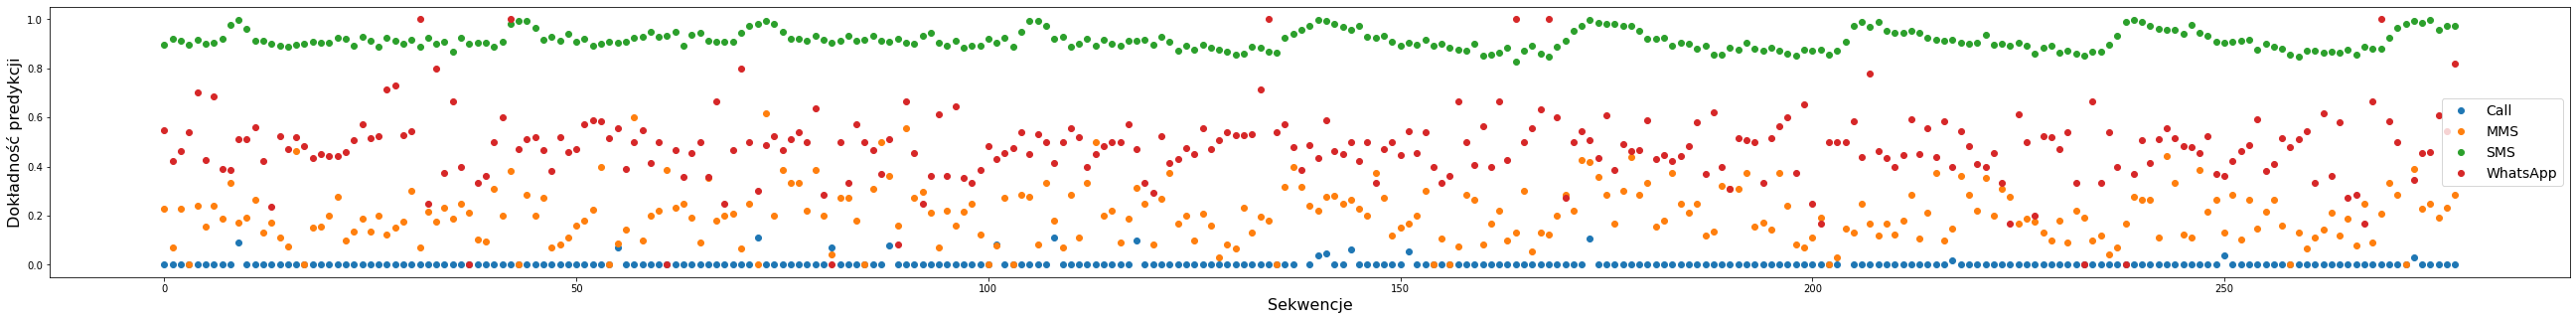

In [66]:
plotAccByType(acc_by_type)

In [67]:
acc_arr = acc_arr.numpy()
all_pred_times = all_pred_times.numpy()
events_predicted = events_predicted.numpy()

print("Średnia dokładność predykcji przyszłych rodzajów zdarzeń: {:.4f}%".format(np.mean(acc_arr)*100))

Średnia dokładność predykcji przyszłych rodzajów zdarzeń: 86.1849%


In [68]:
seq_avgs = np.zeros(n_test)
seq_log_avgs = np.zeros(n_test)

for seq in range(n_test):
    seq_len = len(test_events[seq])
    actual_time = test_times[seq, 1:seq_len]
    actual_time = [i if i != 0 else 1 for i in actual_time]
    predicted_time = all_pred_times[seq, 1:seq_len]
    dT2 = (predicted_time - actual_time)**2
    dT2_avg = np.sum(dT2)/seq_len
    seq_avgs[seq] = dT2_avg
    
print("Pierwiastek z uśrednionego błędu średniokwadratowego wartości czasu dla {} sekwencji testowych: {}".format(n_test, np.sqrt(np.mean(seq_avgs))))

Pierwiastek z uśrednionego błędu średniokwadratowego wartości czasu dla 279 sekwencji testowych: 3210.780920635499


In [69]:
def calcAccForAllEpoches():
    for epoch in range(n_epoch):
        try:
            net = torch.load("./social-interactions/{}/model_{}_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, windows_p, epoch+1))

        except:
            print("No saved network found. Exit")
            return 

        net.to(cuda)

        all_pred_times = torch.ones(n_test, n_seq_max)*-1  # negative time means no event occurred
        acc_by_type = np.zeros((n_test,  n_types)) * -1
        acc_arr = torch.zeros(n_test)

        for idx in tqdm(range(n_test), position=0, leave=True):
          seq_len = len(test_events[idx])
          seq_events, seq_labels, times = getDetails(t_events, t_events_ids, t_times, idx, seq_len)
          times_predicted, events_predicted, correct_pred  = singleSeqThinningAlgorithm(net, seq_events, seq_labels, times)
          number_of_true_pred_types, number_of_types, acc_values_by_type = getAccByType(events_predicted, seq_labels)

          acc_by_type[idx] = acc_values_by_type
          acc_arr[idx] = torch.sum(correct_pred)/len(correct_pred)
          all_pred_times[idx, :seq_len] = times_predicted
        acc_arr = acc_arr.numpy()
        all_pred_times = all_pred_times.numpy()
        events_predicted = events_predicted.numpy()

        print("Średnia dokładność predykcji przyszłych rodzajów zdarzeń dla {}: {:.4f}%".format(epoch+1, np.mean(acc_arr)*100))
        
calcAccForAllEpoches()        

No saved network found. Exit
